In [1]:
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split
from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import transforms
import datetime

In [2]:
X_train = np.load(r"C:\Users\bches\Classes\Spring_2021\Pattern_Recognition\Project\datasets\FER2013\train\X_train.npy")
y_train = np.load(r"C:\Users\bches\Classes\Spring_2021\Pattern_Recognition\Project\datasets\FER2013\train\y_train.npy")
X_val = np.load(r"C:\Users\bches\Classes\Spring_2021\Pattern_Recognition\Project\datasets\FER2013\train\X_val.npy")
y_val = np.load(r"C:\Users\bches\Classes\Spring_2021\Pattern_Recognition\Project\datasets\FER2013\train\y_val.npy")

In [3]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, np.unique(y_train, return_counts=True), np.unique(y_val, return_counts=True)

((22967, 48, 48),
 (22967,),
 (5742, 48, 48),
 (5742,),
 (array([0, 1, 2, 3, 4, 5, 6]),
  array([3187,  345, 3265, 5783, 3927, 3887, 2573], dtype=int64)),
 (array([0, 1, 2, 3, 4, 5, 6]),
  array([ 808,   91,  832, 1432, 1038,  943,  598], dtype=int64)))

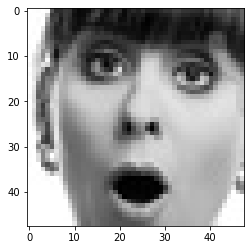

In [6]:
plt.imshow(X_train[50], cmap = 'gray')


In [13]:
#convert data from numpy to tensors
X_train_t = torch.tensor(X_train.tolist(), dtype=torch.float32)/255
y_train_t = torch.tensor(y_train.tolist(), dtype=torch.long)
X_val_t = torch.tensor(X_val.tolist(), dtype=torch.float32)/255
y_val_t = torch.tensor(y_val.tolist(), dtype=torch.long)


X_train_t.type(torch.float32)
y_train_t.type(torch.float32)
X_val_t.type(torch.float32)
y_val_t.type(torch.float32)

X_train_t.shape, X_train_t.type, y_train_t.shape, X_val_t.shape

(torch.Size([22967, 48, 48]),
 <function Tensor.type>,
 torch.Size([22967]),
 torch.Size([5742, 48, 48]))

In [8]:
#pytorch tensors require N X C X H X W 
X_train_t = X_train_t.unsqueeze(1).contiguous()
X_val_t = X_val_t.unsqueeze(1).contiguous()

X_train_t.shape, X_val_t.shape, y_train_t[0].type

(torch.Size([22967, 1, 48, 48]),
 torch.Size([5742, 1, 48, 48]),
 <function Tensor.type>)

In [9]:
y_train_t.shape, y_train_t

(torch.Size([22967]), tensor([2, 3, 3,  ..., 3, 5, 0]))

In [10]:
X_train_t.min(), X_train_t.max(), X_val_t.min(), X_val_t.max(), y_train_t.min(), y_train_t.max(), y_val_t.min(), y_val_t.max() #double check to make sure min is 0 and max is 1 

(tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0),
 tensor(6),
 tensor(0),
 tensor(6))

In [11]:
X_train_t.view(1,-1).mean(dim=1), X_train_t.view(1,-1).std(dim=1) #check mean and std deviation values

(tensor([0.5076]), tensor([0.2548]))

In [12]:
train_mean = X_train_t.view(1,-1).mean(dim=1)
train_std = X_train_t.view(1,-1).std(dim=1)


print(train_mean, train_std)

val_mean = X_val_t.view(1,-1).mean(dim=1)
val_std = X_val_t.view(1,-1).std(dim=1)

tensor([0.5076]) tensor([0.2548])


In [24]:
train_transform = torchvision.transforms.Compose([
            #torchvision.ToPILImage(), #need this to do data augmentation, only accepts PIL images
            #torchvision.transforms.Resize(48), #48 is FER2013 size
            #torchvision.transforms.ToTensor(),
            transforms.Normalize(mean=train_mean, std=train_std)
])

val_transform = torchvision.transforms.Compose([
            #torchvision.ToPILImage(), #need this to do data augmentation, only accepts PIL images
            #torchvision.transforms.Resize(48), #48 is FER2013 size
            #torchvision.transforms.ToTensor(),
            transforms.Normalize(mean=train_mean, std=train_std)
])

val_transform_test = torchvision.transforms.Compose([
            #torchvision.ToPILImage(), #need this to do data augmentation, only accepts PIL images
            #torchvision.transforms.Resize(48), #48 is FER2013 size
            #torchvision.transforms.ToTensor(),
            transforms.Normalize(mean=val_mean, std=val_std)
])

In [13]:
#data set class definition

class my_dataset(Dataset):
    def __init__(self, X, y, transform = None):
        self.data = X
        self.target = y
        self.transform = transform
        
        if torch.cuda.is_available():
            print("Data placed in GPU memory")
            self.data = self.data.cuda()
            self.target = self.target.cuda()
            
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        if self.transform:
            x = self.transform(x)
        
        if torch.cuda.is_available():
            return x.cuda(), y.cuda()
        
        return x,y
        
    def __len__(self):
        return len(self.data)
    

In [14]:
num_classes = 7

class baseline_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        print("model device:", self.device)
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 3, padding = 1) 
        self.conv2 = nn.Conv2d(10, 32, kernel_size = 3, padding = 1) 

        self.fc1 = nn.Linear(32*12*12, 100)

        self.fc2 = nn.Linear(100, num_classes) 


        
    def forward(self, x):
        out = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2) #kernel of 2 for max pool
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = out.view(-1, 32*12*12)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [15]:
num_classes = 7

class baseline_net_dp(nn.Module):
    def __init__(self):
        super().__init__()
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        print("model device:", self.device)
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 3, padding = 1) 
        self.dp1 = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(10, 32, kernel_size = 3, padding = 1) 
        self.dp2 = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(32*12*12, 100)

        self.fc2 = nn.Linear(100, num_classes) 


        
    def forward(self, x):
        out = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2) #kernel of 2 for max pool
        out = self.dp1(out)
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = self.dp2(out)
        out = out.view(-1, 32*12*12)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [16]:
num_classes = 7

class baseline_net_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        print("model device:", self.device)
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 3, padding = 1) 
        self.dp1 = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(10, 32, kernel_size = 3, padding = 1) 
        self.dp2 = nn.Dropout2d(p=0.4)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) 
        self.dp3 = nn.Dropout2d(p=0.4)
        self.conv4 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) 
        self.dp4 = nn.Dropout2d(p=0.4)
        
        
        self.fc1 = nn.Linear(128*3*3, 100)

        self.fc2 = nn.Linear(100, num_classes) 


        
    def forward(self, x):
        out = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2) #kernel of 2 for max pool
        out = self.dp1(out)
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = self.dp2(out)
        out = F.max_pool2d(F.relu(self.conv3(out)), kernel_size=2) #kernel of 2 for max pool
        out = self.dp3(out)
        out = F.max_pool2d(F.relu(self.conv4(out)), 2)
        out = self.dp4(out)
        out = out.view(-1, 128*3*3)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [17]:
num_classes = 7

class baseline_net_bn(nn.Module):
    def __init__(self):
        super().__init__()
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        print("model device:", self.device)
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 3, padding = 1) 
        self.bn1 = nn.BatchNorm2d(num_features = 10)
        self.conv2 = nn.Conv2d(10, 32, kernel_size = 3, padding = 1) 
        self.bn2 = nn.BatchNorm2d(num_features = 32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) 
        self.bn3 = nn.BatchNorm2d(num_features = 64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)         
        self.bn4 = nn.BatchNorm2d(num_features = 128)

        self.fc1 = nn.Linear(128*3*3, 100)

        self.fc2 = nn.Linear(100, num_classes) 


        
    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = F.max_pool2d(F.relu(out), kernel_size=2) #kernel of 2 for max pool
        out = self.bn2(self.conv2(out))
        out = F.max_pool2d(F.relu(out), 2)
        out = self.bn3(self.conv3(out))
        out = F.max_pool2d(F.relu(out), kernel_size=2) #kernel of 2 for max pool
        out = self.bn4(self.conv4(out))
        out = F.max_pool2d(F.relu(out), 2)
        out = out.view(-1, 128*3*3)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [18]:
train_errors = []
val_errors = []
#val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle=True)

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    patience = 50 #50 epoch patience for early stopping
    if model.use_cuda:
      if(torch.cuda.device_count() > 1):
        print("Using data parallel for training model")
        model = nn.DataParallel(model)
      model = model.to(model.device)
    for epoch in range(1, n_epochs+1):
        
        loss_train = 0.0
        val_loss = 0.0
        correct_train = 0
        total_train = 0
        model.train()
        for imgs, labels in train_loader:
            #print(imgs.shape, labels.shape)
            #print(imgs)
            outputs = model(imgs)
            #print(outputs, labels)

            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            #print(outputs)
            _, pred1 = torch.max(outputs, dim=1)
            #print(pred1)
            #print(torch.max(outputs,dim=1))
            total_train += labels.shape[0]
            correct_train += (pred1==labels).sum()
            #train_acc = 100*correct_train/total_train
            
        train_errors.append(loss_train)
        
        total = 0
        correct = 0
        with torch.no_grad():
            model.eval()
            for imgs1, label in val_loader:
                outputs1 = model(imgs1)
                #print(outputs1)
                _, pred = torch.max(outputs1, dim=1)
                total += label.shape[0]
                correct += (pred == label).sum()
                val_loss += loss_fn(outputs1, label)
                val_errors.append(val_loss)
        #print("Validation accuracy: ", 100*correct/total)
        
        if epoch == 1 or epoch % 10 == 0:
              print('{} Epoch {}, Training loss {}, Training accuracy {} Validation accuracy {}'.format(datetime.datetime.now(), epoch, float(loss_train), float(100*correct_train/total_train), float(100*correct/total)))

In [19]:
train_dataset = my_dataset(X_train_t, y_train_t, transform=train_transform)

val_dataset = my_dataset(X_val_t, y_val_t, transform=val_transform)


Data placed in GPU memory
Data placed in GPU memory


In [20]:
#taken from Haotians Lenet code, cite this if submitting it
def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.orthogonal_(m.weight)
    if type(m) == nn.Linear:
        nn.init.orthogonal_(m.weight)

In [21]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model = baseline_net_bn()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
sum(p.numel() for p in model.parameters())

model device: cuda


211839

In [22]:
model.apply(init_weights) #initialize weights to have orthogonal projection

baseline_net_bn(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=7, bias=True)
)

In [23]:
training_loop(
    n_epochs = 20, 
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader)

2021-04-21 11:30:03.361785 Epoch 1, Training loss 334.8934953212738, Training accuracy 26.163625717163086 Validation accuracy 31.34796142578125
2021-04-21 11:32:00.312691 Epoch 10, Training loss 115.4477832019329, Training accuracy 76.66216278076172 Validation accuracy 54.022987365722656
2021-04-21 11:34:11.071577 Epoch 20, Training loss 26.107586156576872, Training accuracy 95.03199768066406 Validation accuracy 54.26680374145508


In [25]:
val_dataset_test = my_dataset(X_val_t, y_val_t, transform=val_transform_test)
val_loader_test = torch.utils.data.DataLoader(val_dataset_test, batch_size=batch_size, shuffle=False)

training_loop(
    n_epochs = 20, 
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader_test)

Data placed in GPU memory
2021-04-21 11:35:52.472308 Epoch 1, Training loss 27.210413344204426, Training accuracy 94.81864929199219 Validation accuracy 52.17694091796875
2021-04-21 11:37:47.618337 Epoch 10, Training loss 14.955113135278225, Training accuracy 97.31352996826172 Validation accuracy 53.74433898925781
2021-04-21 11:39:57.173332 Epoch 20, Training loss 11.369155581342056, Training accuracy 97.97534942626953 Validation accuracy 53.06513214111328
